In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
gP = np.random.normal(1, .1, size=n) #proportional
gD = np.random.normal(1, .25, size=n) #derivative
gI = np.random.normal(1, .25, size=n) #integral

phat0 = gP*F0/S0 #derivative, integral and proportion
#agents as controllers, co-steering

#wakeup rates
gamma =  sts.expon.rvs(loc=1,scale=5, size=n)

#holdings fiat
h = sts.expon.rvs( loc=10,scale=10, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

(array([52., 26., 10.,  7.,  1.,  0.,  2.,  1.,  0.,  1.]),
 array([ 1.0338922 ,  5.23211332,  9.43033443, 13.62855555, 17.82677667,
        22.02499779, 26.22321891, 30.42144003, 34.61966114, 38.81788226,
        43.01610338]),
 <a list of 10 Patch objects>)

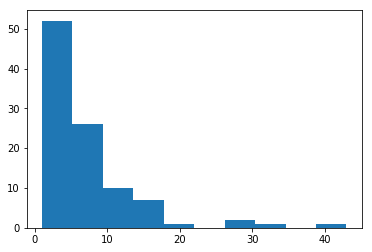

In [4]:
plt.hist(gamma)

In [5]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [(gP,gD,gI)],
    'rates':[1/gamma],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0],
    'dust' : [dust]}

In [6]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'actions': {}}

In [7]:
initial_conditions

{'actions': {},
 'funds': 50000.0,
 'holdings': array([24.09528489, 18.79298845, 13.33464247, 22.57072785, 11.30193801,
        35.6723863 , 25.73856137, 53.90755112, 19.35512643, 27.76532644,
        13.35687278, 36.34742556, 10.51251499, 22.29168718, 30.89572816,
        17.17619821, 21.37890477, 17.03712454, 10.16595742, 13.6018989 ,
        13.41300478, 21.24450078, 15.93682469, 11.03391066, 20.94768655,
        16.09410736, 10.29323006, 14.82911864, 10.59618054, 16.2394467 ,
        19.16160133, 27.85854368, 16.02711721, 10.87953373, 40.69861243,
        19.10459552, 13.60860895, 18.55766669, 13.01121822, 13.73894803,
        35.94528666, 23.16941157, 21.57342552, 22.56177821, 10.96755118,
        15.28590854, 13.92521606, 31.18578229, 10.80619574, 30.68266575,
        30.28339206, 16.71281819, 26.90341212, 13.91756599, 15.20519053,
        32.3526621 , 14.48564978, 15.49807916, 16.84003539, 26.49217228,
        10.60201337, 27.84375775, 25.63555399, 25.74135559, 10.07621718,
    

In [8]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    if delF <1:
        if s['funds'] <1000:
            delF =100
    
    return({'delF':delF})

In [9]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [10]:
def update_prices(params, step, sL, s, _input):
    
    deltaS = s['supply']-sL[-1][-1]['supply']
    deltaF = s['funds']-sL[-1][-1]['funds']
    
    g = params['gains']
    prop = s['funds']/s['supply']
    proj = (s['funds']+deltaF)/(s['supply']+deltaS) #projects last change
    avg = (2*s['funds']-deltaF)/(2*s['supply']-deltaS) #avg with last value
    
    phat = (g[0]*prop + g[1]*proj + g[2]*avg)/3
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [11]:
#change in F (revenue and spending accounted for)
def choose_agents(params, step, sL, s):
    n = params['population']
    rates = params['rates']
    
    agents = []
    for a in range(n):
        sq_gap = (s['spot_price']-s['prices'][a])**2
        pr = (rates[a]+sq_gap)/(1+sq_gap) #rates when sq_gap =0, 1 when sq_gap -> infty
        rv = np.random.rand()
        if rv < pr:
            agents.append(a)
    
    #shuffle
    shuffled_agents =np.random.choice(agents,len(agents), False)     
        
    return({'agents':shuffled_agents})

In [12]:
def agent_actions(params, step, sL, s, _input):
    
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    P=s['spot_price']
    
    actions = []
    for a in _input['agents']:
        h_a = s['holdings'][a]
        phat_a = s['prices'][a]
        s_a =  s['tokens'][a]
        beta = params['beta']

        if P>phat_a: #equiv: pbar(0)>phat_a
            mech = 'burn'
                        
            #approx for burn s.t. p=phat
            #armijo style
            amt = s_a
            
            def pbar(amt):
                output = withdraw_with_tax(amt, R,S, V0, params['phi'], params['kappa'])

                if not(output[2])>0:
                    return np.Infinity
                else:
                    return output[2]

            if amt > 10**-8:
                while pbar(amt)< phat_a:
                    amt = amt*beta

        else: # P<phat_a; #equiv pbar(0)<phat_a
            mech = 'bond'
            #approx for buy s.t. p=phat
            #armijo style
            amt = h_a
  
            def pbar(amt):
                output = mint(amt, R,S, V0, params['kappa'])

                if not(output[1])>0:
                    return 0
                else:
                    return output[1]
                
            if amt > params['dust']:
                while pbar(amt)> phat_a:
                    amt = amt*beta
        
        action = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt),'posterior':{}}
        
        if action['mech'] == 'bond':
            h_a = h_a-amt
            dS, pbar = mint(amt, R,S, V0, params['kappa'])
            R = R+amt
            S = S+dS
            s_a = s_a+dS
            P = spot_price(R, V0, kappa)
    
        elif action['mech'] == 'burn':
            s_a = s_a-amt
            dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
            R = R-dR
            F = F + params['phi']*dR
            S = S-amt
            h_a = h_a + (1-params['phi'])*dR
            P = spot_price(R, V0, kappa)
        
        action['posterior'] = {'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a}
        actions.append(action)
        
    key = 'actions'
    value = actions
    
    return (key, value)

In [13]:
def resolve_actions(params, step, sL, s):
    
    H_a = s['holdings']
    S_a =  s['tokens']
    
    actions = s['actions']
    
    for action in actions:
        a= action['agent']
        H_a[a] = action['posterior']['h_a']
        S_a[a] = action['posterior']['s_a']
    
    #last action only
    F = action['posterior']['F']
    R = action['posterior']['R']
    P = action['posterior']['P']
    S = action['posterior']['S']
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'S_a':S_a, 'H_a':H_a})

In [14]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    H_a = _input['H_a']
    
    key = 'holdings'
    value = H_a
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    S_a = _input['S_a']
    
    sumS = np.sum(S_a)
    S = _input['S']
    
    tokens = S_a*S/sumS
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [15]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agents
        },
        'variables': { 
            'actions': agent_actions, 
        }
    },
    {
      'policies': {
          'act': resolve_actions,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [16]:
time_periods_per_run = 500
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [17]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 500), 'M': {'kappa': 2, 'lambda': 200, 'gains': (array([0.82142135, 1.00700442, 0.95175848, 1.14048482, 1.12210801,
       1.05024737, 0.89668141, 0.99747848, 1.15706646, 0.82371409,
       0.98747647, 0.92634518, 0.925367  , 1.07146578, 0.98787107,
       1.11893675, 1.21720243, 1.01340869, 0.91742414, 0.99159532,
       1.227881  , 0.95725816, 1.05176911, 0.88592493, 1.10111666,
       0.91269148, 0.99495237, 1.05954458, 0.98801726, 0.87574807,
       0.93473118, 0.97113649, 1.11514222, 1.04177646, 1.07021095,
       0.85759425, 0.86161494, 0.89650344, 0.93694189, 1.02368256,
       1.02368508, 1.13704247, 0.85437146, 0.99183981, 1.18351362,
       1.05798426, 0.81656416, 1.19606339, 1.08129214, 0.91377375,
       0.91616619, 0.95332799, 0.87881383, 1.21644241, 0.94725553,
       0.96744963, 0.99570373, 0.91296008, 1.2895848 , 1.25561637,
       1.05709333, 1.14554556, 1.04899566, 1.02639942, 0.96992454,
       0.94909821, 0.87749128, 1.05447425, 0.90729485, 0

In [18]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [19]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a1ee16a90>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a1ee16a90>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS


In [20]:
experiment_index = 0
df = results[experiment_index]['result']

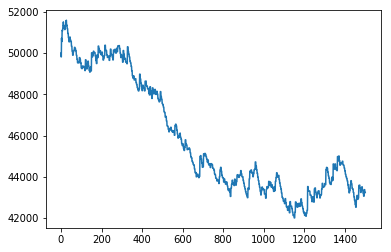

In [21]:
df.funds.plot()

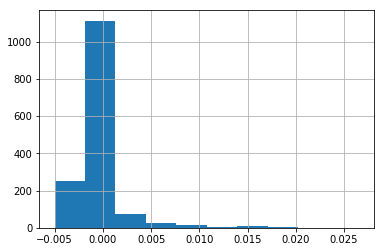

In [22]:
(df.funds.diff()/df.funds).hist()

In [23]:
rdf = df[df.substep == 3].copy()

In [24]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

In [25]:
rdf['holding_wts'] = (rdf.holdings/rdf.holdings.apply(sum))
rdf['h_wt_mean_price'] = (rdf.holding_wts*rdf.prices).apply(sum)

In [26]:
rdf['wealth'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [27]:
rdf['wealth_wts'] = rdf.wealth/rdf.wealth.apply(sum)
rdf['w_wt_mean_price'] = (rdf.wealth_wts*rdf.prices).apply(sum)

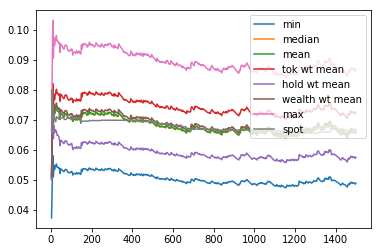

In [28]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

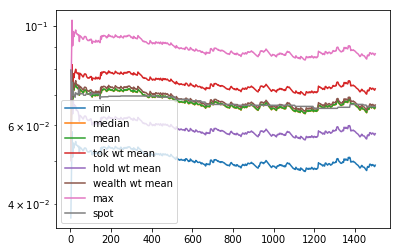

In [29]:
rdf.prices.apply(np.min).plot(logy=True)
rdf.prices.apply(np.median).plot(logy=True)
rdf.prices.apply(np.mean).plot(logy=True)
rdf.wt_mean_price.plot(logy=True)
rdf.h_wt_mean_price.plot(logy=True)
rdf.w_wt_mean_price.plot(logy=True)
rdf.prices.apply(np.max).plot(logy=True)
rdf.spot_price.plot(logy=True)
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [30]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

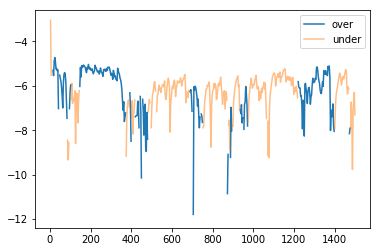

In [31]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [32]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

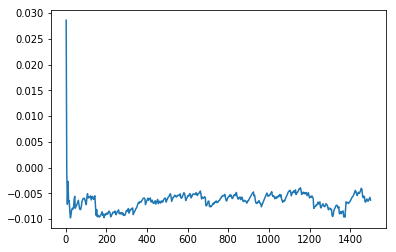

In [33]:
rdf.est_err.plot()

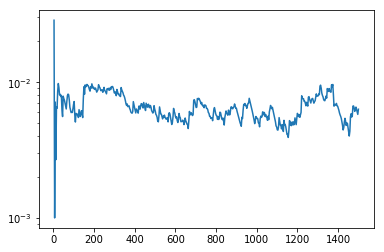

In [34]:
rdf.est_err.apply(np.abs).plot(logy=True)

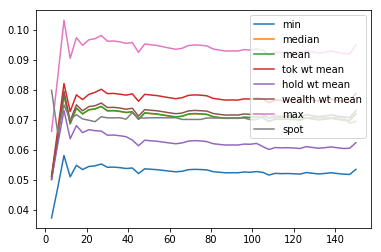

In [35]:
#head T
T = 50
rdf.head(T).prices.apply(np.min).plot()
rdf.head(T).prices.apply(np.median).plot()
rdf.head(T).prices.apply(np.mean).plot()
rdf.head(T).wt_mean_price.plot()
rdf.head(T).h_wt_mean_price.plot()
rdf.head(T).w_wt_mean_price.plot()
rdf.head(T).prices.apply(np.max).plot()
rdf.head(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

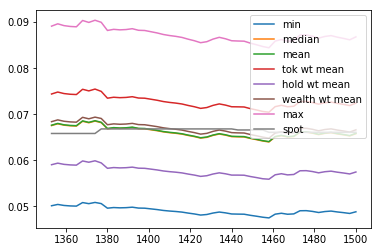

In [36]:
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).h_wt_mean_price.plot()
rdf.tail(T).w_wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [37]:
tx_data = rdf.actions.values
transactions = []
states = []
for t in range(time_periods_per_run):
    for tx in range(len(tx_data[t])):
        states.append(tx_data[t][tx]['posterior'])
        transactions.append(tx_data[t][tx])


In [38]:
sdf = pd.DataFrame(states)
tdf = pd.DataFrame(transactions).drop('posterior', axis=1)

In [39]:
tdf.head()

,agent,amt,mech,pbar
0,52,14310.936125,burn,0.094320
1,9,10071.500672,burn,0.093162
2,32,7692.336049,burn,0.092318
3,66,5385.911902,burn,0.091697
4,97,5266.511564,burn,0.091191


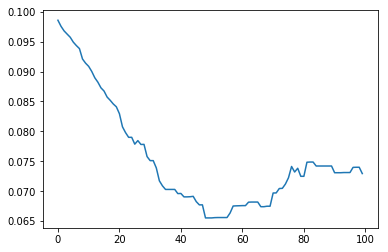

In [40]:
sdf['P'].head(100).plot()

In [41]:
bond_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='bond']
burn_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='burn']

(array([209.,   0.,   9.,   4.,   4.,   1.,   0.,   1.,   2.,   1.]),
 array([   0.        ,  173.36418813,  346.72837626,  520.09256439,
         693.45675253,  866.82094066, 1040.18512879, 1213.54931692,
        1386.91350505, 1560.27769318, 1733.64188131]),
 <a list of 10 Patch objects>)

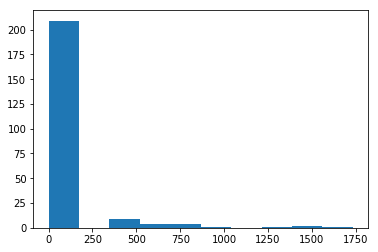

In [42]:
plt.hist(bond_amts)

(array([209.,   0.,  24.,  13.,   8.,   7.,   2.,   1.,   1.,   4.]),
 array([    0.        ,  2196.41467013,  4392.82934026,  6589.24401039,
         8785.65868052, 10982.07335065, 13178.48802078, 15374.90269091,
        17571.31736103, 19767.73203116, 21964.14670129]),
 <a list of 10 Patch objects>)

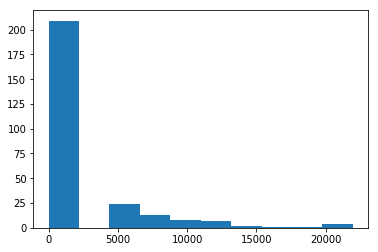

In [43]:
plt.hist(burn_amts)

In [44]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

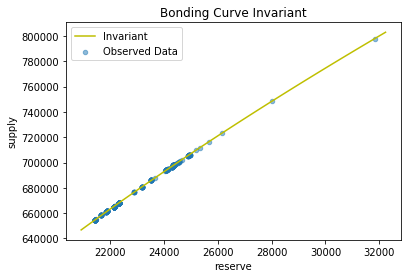

In [45]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

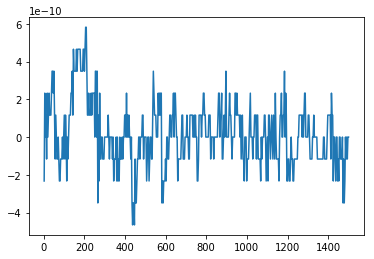

In [46]:
(rdf.tokens.apply(sum)-rdf.supply).plot()

In [47]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

(array([57.,  1., 15.,  9.,  4.,  6.,  4.,  0.,  2.,  2.]),
 array([   0.        ,  150.66342653,  301.32685307,  451.9902796 ,
         602.65370614,  753.31713267,  903.98055921, 1054.64398574,
        1205.30741228, 1355.97083881, 1506.63426535]),
 <a list of 10 Patch objects>)

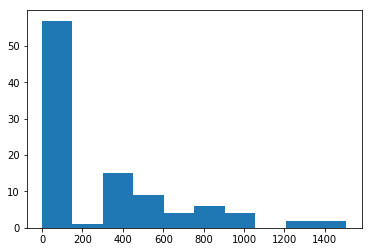

In [48]:
plt.hist(rdf.iloc[-1].holdings)

In [49]:
rdf['gini_h'] = rdf.holdings.apply(gini)

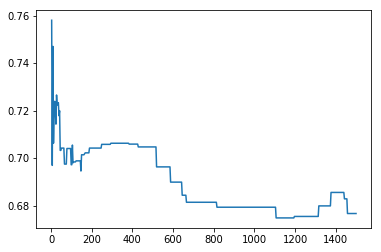

In [50]:
rdf.gini_h.plot()

(array([42.,  0., 12., 18.,  8.,  5.,  1.,  8.,  2.,  4.]),
 array([    0.        ,  2365.58089361,  4731.16178722,  7096.74268082,
         9462.32357443, 11827.90446804, 14193.48536165, 16559.06625525,
        18924.64714886, 21290.22804247, 23655.80893608]),
 <a list of 10 Patch objects>)

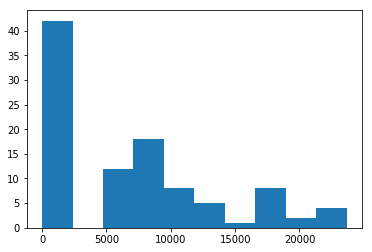

In [51]:
plt.hist(rdf.iloc[-1].tokens)

In [52]:
rdf['gini_s'] = rdf.tokens.apply(gini)

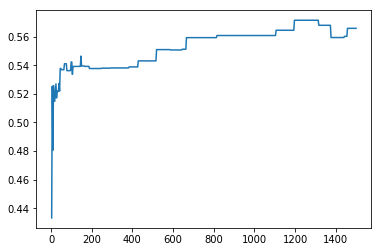

In [53]:
rdf.gini_s.plot()

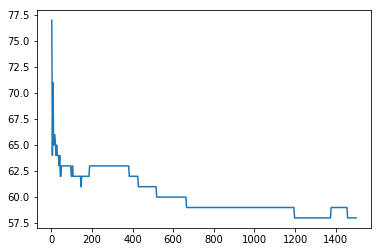

In [54]:
rdf.tokens.apply(np.count_nonzero).plot()

In [55]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

(array([24., 23., 11., 13.,  7.,  3.,  6.,  5.,  3.,  5.]),
 array([ 317.57944423,  442.14574163,  566.71203903,  691.27833643,
         815.84463383,  940.41093123, 1064.97722863, 1189.54352603,
        1314.10982343, 1438.67612082, 1563.24241822]),
 <a list of 10 Patch objects>)

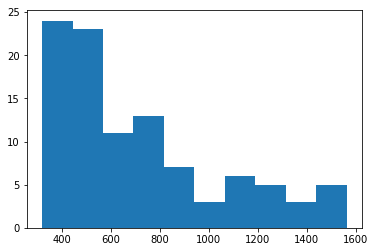

In [56]:
plt.hist(rdf.iloc[-1].asset_value)

In [57]:
rdf['gini'] = rdf.asset_value.apply(gini)

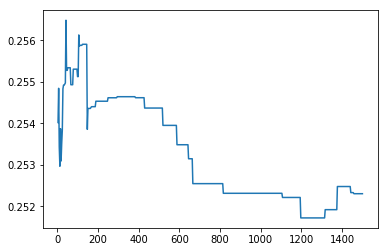

In [58]:
rdf.gini.plot()

In [59]:
rdf['pref_gap'] = (rdf.prices - rdf.spot_price)/rdf.spot_price

([array([11., 16., 21., 22., 13., 13.,  4.]),
  array([11., 15., 20., 22., 15., 13.,  4.]),
  array([10., 16., 19., 21., 16., 14.,  4.]),
  array([11., 15., 20., 23., 14., 13.,  4.]),
  array([11., 16., 21., 22., 13., 13.,  4.]),
  array([15., 12., 21., 22., 16., 10.,  4.]),
  array([11., 15., 20., 22., 15., 13.,  4.])],
 array([-0.26635285, -0.1829426 , -0.09953236, -0.01612212,  0.06728812,
         0.15069836,  0.2341086 ,  0.31751884]),
 <a list of 7 Lists of Patches objects>)

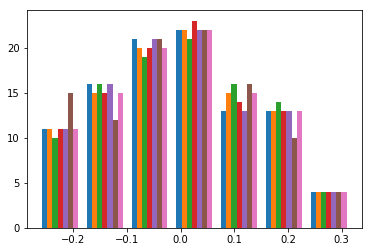

In [60]:
plt.hist(rdf.iloc[-7:].pref_gap, bins=7)